# Project Overview
This project involves the analysis of field agents at company X, who capture and collect information about farmers, ranging from KYC data to the polygon/outlines of a farmer's field. The aim is to design an effective incentive structure to motivate the field agents and improve their productivity by rewarding the agents based on their input.

# Problem Statement
As Company X tracks the number of tasks completed by each field agents daily over a 83-days period, it aims to design an incentive structure that motivates agents, particularly those close to the top performers who need to reach their full potential. The challenge is to create a fair and effective incentive plan that motivates all the field agents while maintaining the average compensation per task at a minimum of Ksh 175 and a maximum of Ksh 300.

# Objectives
1. To analyze individual and overall agents performance by calculating mean, median, standard deviation, minimum and maximum of the number of tasks completed.
2. To design an easy to understand and implement incentive  by;
- Developing a per-task payment rate that meets the financial criteria.
- Proposing a weekly performance bonus to motivate the agents near the top performers.
3. To offer data-driven insights into agent performance and recommend ways to improve agent productivity and satisfaction.

In [5]:
# Loading the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [12]:
# Loading the dataset
df = pd.read_excel(r"C:\Users\ADMIN\IncentiveStructure\IncentiveStructure-1\docs\Synthetic Agent Data.xlsx")
df.head()

,Unnamed: 0,Agent 0,Agent 1,Agent 2,Agent 3,Agent 4,Agent 5,Agent 6,Agent 7,Agent 8,...,Agent 1190,Agent 1191,Agent 1192,Agent 1193,Agent 1194,Agent 1195,Agent 1196,Agent 1197,Agent 1198,Agent 1199
0,0,1,2,1,0,1,1,0,0,0,...,0,2,2,0,2,0,0,0,1,0
1,1,9,10,8,2,15,7,0,2,2,...,0,9,8,0,14,0,1,0,7,1
2,2,9,7,11,3,10,7,0,1,3,...,3,9,10,0,9,0,2,1,12,0
3,3,11,14,13,0,8,9,0,0,3,...,1,14,11,1,7,2,3,1,10,2
4,4,11,13,7,1,7,8,1,0,4,...,2,14,8,0,7,1,2,1,15,1


In [13]:
# Getting the information on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Columns: 1201 entries, Unnamed: 0 to Agent 1199
dtypes: int64(1201)
memory usage: 788.3 KB


## Data cleaning

In [17]:
# Checking for missing values
df.isnull().sum()


Unnamed: 0    0
Agent 0       0
Agent 1       0
Agent 2       0
Agent 3       0
             ..
Agent 1195    0
Agent 1196    0
Agent 1197    0
Agent 1198    0
Agent 1199    0
Length: 1201, dtype: int64

**Inference**: There is no missing values.

In [18]:
# Dropping the first column
df = df.iloc[:,1:]
df.head()

,Agent 0,Agent 1,Agent 2,Agent 3,Agent 4,Agent 5,Agent 6,Agent 7,Agent 8,Agent 9,Agent 10,Agent 11,Agent 12,Agent 13,Agent 14,Agent 15,Agent 16,Agent 17,Agent 18,Agent 19,Agent 20,Agent 21,Agent 22,Agent 23,Agent 24,Agent 25,Agent 26,Agent 27,Agent 28,Agent 29,Agent 30,Agent 31,Agent 32,Agent 33,Agent 34,Agent 35,Agent 36,Agent 37,Agent 38,Agent 39,Agent 40,Agent 41,Agent 42,Agent 43,Agent 44,Agent 45,Agent 46,Agent 47,Agent 48,Agent 49,Agent 50,Agent 51,Agent 52,Agent 53,Agent 54,Agent 55,Agent 56,Agent 57,Agent 58,Agent 59,Agent 60,Agent 61,Agent 62,Agent 63,Agent 64,Agent 65,Agent 66,Agent 67,Agent 68,Agent 69,Agent 70,Agent 71,Agent 72,Agent 73,Agent 74,Agent 75,Agent 76,Agent 77,Agent 78,Agent 79,Agent 80,Agent 81,Agent 82,Agent 83,Agent 84,Agent 85,Agent 86,Agent 87,Agent 88,Agent 89,Agent 90,Agent 91,Agent 92,Agent 93,Agent 94,Agent 95,Agent 96,Agent 97,Agent 98,Agent 99,Agent 100,Agent 101,Agent 102,Agent 103,Agent 104,Agent 105,Agent 106,Agent 107,Agent 108,Agent 109,Agent 110,Agent 111,Agent 112,Agent 113,Agent 114,Agent 115,Agent 116,Agent 117,Agent 118,Agent 119,Agent 120,Agent 121,Agent 122,Agent 123,Agent 124,Agent 125,Agent 126,Agent 127,Agent 128,Agent 129,Agent 130,Agent 131,Agent 132,Agent 133,Agent 134,Agent 135,Agent 136,Agent 137,Agent 138,Agent 139,Agent 140,Agent 141,Agent 142,Agent 143,Agent 144,Agent 145,Agent 146,Agent 147,Agent 148,Agent 149,Agent 150,Agent 151,Agent 152,Agent 153,Agent 154,Agent 155,Agent 156,Agent 157,Agent 158,Agent 159,Agent 160,Agent 161,Agent 162,Agent 163,Agent 164,Agent 165,Agent 166,Agent 167,Agent 168,Agent 169,Agent 170,Agent 171,Agent 172,Agent 173,Agent 174,Agent 175,Agent 176,Agent 177,Agent 178,Agent 179,Agent 180,Agent 181,Agent 182,Agent 183,Agent 184,Agent 185,Agent 186,Agent 187,Agent 188,Agent 189,Agent 190,Agent 191,Agent 192,Agent 193,Agent 194,Agent 195,Agent 196,Agent 197,Agent 198,Agent 199,Agent 200,Agent 201,Agent 202,Agent 203,Agent 204,Agent 205,Agent 206,Agent 207,Agent 208,Agent 209,Agent 210,Agent 211,Agent 212,Agent 213,Agent 214,Agent 215,Agent 216,Agent 217,Agent 218,Agent 219,Agent 220,Agent 221,Agent 222,Agent 223,Agent 224,Agent 225,Agent 226,Agent 227,Agent 228,Agent 229,Agent 230,Agent 231,Agent 232,Agent 233,Agent 234,Agent 235,Agent 236,Agent 237,Agent 238,Agent 239,Agent 240,Agent 241,Agent 242,Agent 243,Agent 244,Agent 245,Agent 246,Agent 247,Agent 248,Agent 249,Agent 250,Agent 251,Agent 252,Agent 253,Agent 254,Agent 255,Agent 256,Agent 257,Agent 258,Agent 259,Agent 260,Agent 261,Agent 262,Agent 263,Agent 264,Agent 265,Agent 266,Agent 267,Agent 268,Agent 269,Agent 270,Agent 271,Agent 272,Agent 273,Agent 274,Agent 275,Agent 276,Agent 277,Agent 278,Agent 279,Agent 280,Agent 281,Agent 282,Agent 283,Agent 284,Agent 285,Agent 286,Agent 287,Agent 288,Agent 289,Agent 290,Agent 291,Agent 292,Agent 293,Agent 294,Agent 295,Agent 296,Agent 297,Agent 298,Agent 299,Agent 300,Agent 301,Agent 302,Agent 303,Agent 304,Agent 305,Agent 306,Agent 307,Agent 308,Agent 309,Agent 310,Agent 311,Agent 312,Agent 313,Agent 314,Agent 315,Agent 316,Agent 317,Agent 318,Agent 319,Agent 320,Agent 321,Agent 322,Agent 323,Agent 324,Agent 325,Agent 326,Agent 327,Agent 328,Agent 329,Agent 330,Agent 331,Agent 332,Agent 333,Agent 334,Agent 335,Agent 336,Agent 337,Agent 338,Agent 339,Agent 340,Agent 341,Agent 342,Agent 343,Agent 344,Agent 345,Agent 346,Agent 347,Agent 348,Agent 349,Agent 350,Agent 351,Agent 352,Agent 353,Agent 354,Agent 355,Agent 356,Agent 357,Agent 358,Agent 359,Agent 360,Agent 361,Agent 362,Agent 363,Agent 364,Agent 365,Agent 366,Agent 367,Agent 368,Agent 369,Agent 370,Agent 371,Agent 372,Agent 373,Agent 374,Agent 375,Agent 376,Agent 377,Agent 378,Agent 379,Agent 380,Agent 381,Agent 382,Agent 383,Agent 384,Agent 385,Agent 386,Agent 387,Agent 388,Agent 389,Agent 390,Agent 391,Agent 392,Agent 393,Agent 394,Agent 395,Agent 396,Agent 397,Agent 398,Agent 399,Agent 400,Agent 401,Agent 402,Agent 403,Agent 404,Agent 405,Agent 406,Agent 407,Agent 408,Agent 409,Agent 410

So that each row represents each agent number and each column represents each day, we can transpose the data for better representation of the dataset. we can also rename the columns to represent days for the entire 83-days period.

In [20]:
# Transposing the dataset and renaming the columns
df_transposed = df.transpose()
df_transposed.columns = [f'Day_{i}' for i in range(df_transposed.shape[1])]
df_transposed.head()

,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Day_32,Day_33,Day_34,Day_35,Day_36,Day_37,Day_38,Day_39,Day_40,Day_41,Day_42,Day_43,Day_44,Day_45,Day_46,Day_47,Day_48,Day_49,Day_50,Day_51,Day_52,Day_53,Day_54,Day_55,Day_56,Day_57,Day_58,Day_59,Day_60,Day_61,Day_62,Day_63,Day_64,Day_65,Day_66,Day_67,Day_68,Day_69,Day_70,Day_71,Day_72,Day_73,Day_74,Day_75,Day_76,Day_77,Day_78,Day_79,Day_80,Day_81,Day_82,Day_83
Agent 0,1,9,9,11,11,8,1,2,12,7,12,11,7,1,1,9,7,7,7,12,2,1,7,7,11,7,7,2,2,10,9,8,10,7,2,1,8,7,8,11,11,1,2,11,14,7,12,9,2,2,12,8,14,10,7,1,2,7,9,8,7,12,1,2,11,10,11,8,7,2,2,8,10,10,7,7,1,2,7,8,7,11,9,2
Agent 1,2,10,7,14,13,11,2,2,9,7,7,8,7,1,1,9,8,10,15,7,1,1,7,7,7,9,8,1,2,9,13,7,7,11,1,1,9,10,7,7,7,1,2,7,9,7,7,7,2,2,8,14,7,8,9,1,1,8,14,7,7,8,2,2,7,10,13,10,9,1,1,7,7,7,14,8,1,2,7,8,11,7,9,2
Agent 2,1,8,11,13,7,14,2,2,15,13,7,8,13,1,2,8,11,7,12,11,2,2,8,11,8,7,8,1,2,15,7,12,7,7,1,1,12,7,8,9,7,1,1,11,7,9,11,10,2,1,9,8,7,9,7,1,1,8,8,8,14,8,2,1,8,8,7,8,13,2,2,7,7,10,7,9,2,1,9,7,7,9,11,2
Agent 3,0,2,3,0,1,0,0,0,0,1,1,2,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,2,3,0,1,0,0,2,1,0,0,2,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,0,2,2,1,0,0,0,0,3,0,0,0,2,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0
Agent 4,1,15,10,8,7,12,2,2,8,8,11,7,9,1,1,8,14,9,15,14,1,1,10,7,8,8,15,2,2,10,8,11,8,7,1,2,14,7,7,13,11,1,1,8,9,8,8,9,2,2,10,14,10,9,8,2,2,7,8,9,7,10,2,2,9,7,7,8,7,1,1,13,15,13,7,10,2,2,9,10,7,13,7,2


In [24]:
# print the new dataset
print(df_transposed)

            Day_0  Day_1  Day_2  Day_3  Day_4  Day_5  Day_6  Day_7  Day_8  \
Agent 0         1      9      9     11     11      8      1      2     12   
Agent 1         2     10      7     14     13     11      2      2      9   
Agent 2         1      8     11     13      7     14      2      2     15   
Agent 3         0      2      3      0      1      0      0      0      0   
Agent 4         1     15     10      8      7     12      2      2      8   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
Agent 1195      0      0      0      2      1      0      0      0      0   
Agent 1196      0      1      2      3      2      3      0      0      3   
Agent 1197      0      0      1      1      1      1      0      0      0   
Agent 1198      1      7     12     10     15      7      1      2      7   
Agent 1199      0      1      0      2      1      0      0      0      2   

            Day_9  Day_10  Day_11  Day_12  Day_13  Day_14  Day_15  Day_16  

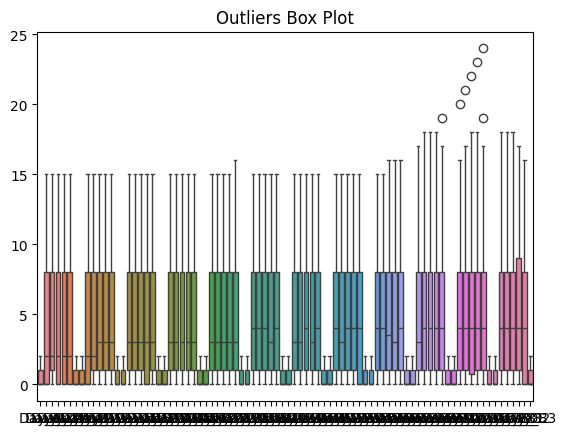

In [32]:
# Checking for outliers using the box plot technique
plt.Figure(figsize=(14,6))
sns.boxplot(data=df_transposed)
plt.title('Outliers Box Plot')
plt.show()

**Inference**: There are minimal outliers detected as shown by the points 

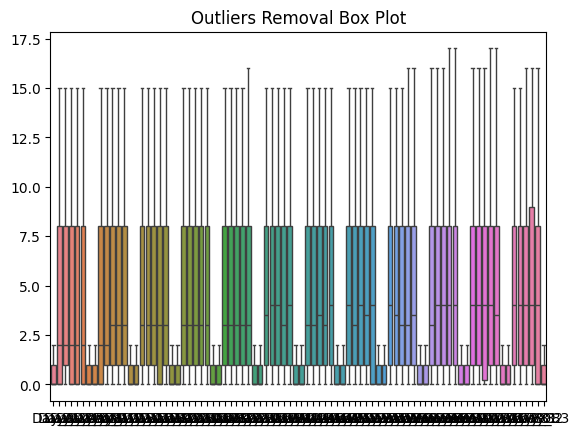

In [34]:
# Removing outliers using the IQR method
Q1 = df_transposed.quantile(0.25)
Q3 = df_transposed.quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df_transposed[~((df_transposed < (Q1 - 1.5 * IQR)) | (df_transposed > (Q3 + 1.5 * IQR))).any(axis=1)]

# Confirm outliers removal by plotting a box plot
plt.Figure(figsize=(14,6))
sns.boxplot(data=df_no_outliers)
plt.title('Outliers Removal Box Plot')
plt.show()

Now that our dataset is cleaned and has no outliers, we can proceed to the statistical analysis.

# Statistical Analysis
The Python code below gives the statistical calculations (Mean, Median, Minimum, Maximum and Standard deviation of the number of tasks completed per day by each field agent)

In [36]:
# Calculating Mean, Median, Max, and sd (Individual stats)
AgentStats = pd.DataFrame()  # Create a data-frame to store the statistics
AgentStats['Mean'] = df_no_outliers.mean(axis=1)
AgentStats['Median'] = df_no_outliers.median(axis=1)
AgentStats['Sd'] = df_no_outliers.std(axis=1)
AgentStats['Minimum'] = df_no_outliers.min(axis=1)
AgentStats['Maximum'] = df_no_outliers.max(axis=1)

print(AgentStats)

                Mean  Median        Sd  Minimum  Maximum
Agent 0     6.940476     7.0  3.816108        1       14
Agent 1     6.702381     7.0  3.867628        1       15
Agent 2     7.000000     7.5  4.032996        1       15
Agent 3     0.535714     0.0  0.870486        0        3
Agent 4     7.297619     8.0  4.236331        1       15
...              ...     ...       ...      ...      ...
Agent 1195  0.309524     0.0  0.559177        0        2
Agent 1196  2.083333     2.0  1.716036        0        6
Agent 1197  1.714286     1.0  1.923673        0        8
Agent 1198  7.285714     7.0  4.249937        1       15
Agent 1199  0.595238     0.0  0.879746        0        3

[1198 rows x 5 columns]


**Inferences**
- Looking at the standard deviation of each field agent, it shows a variability in the number of tasks performed per day ranging from 0 to 5 task, with numbers close to 0 indicating low variability whereas those close to 5 indicate a higher variability. 

In [38]:
# Calculating Mean, Median, Max, and sd (Overall stats)
OverallStats = pd.DataFrame()  # Create a data-frame to store the statistics
OverallStats['Mean'] = [df_no_outliers.values.mean()]
OverallStats['Median'] = [np.median(df_no_outliers.values)]
OverallStats['Sd'] = [df_no_outliers.values.std()]
OverallStats['Minimum'] = [df_no_outliers.values.min()]
OverallStats['Maximum'] = [df_no_outliers.values.max()]

print(OverallStats)

       Mean  Median       Sd  Minimum  Maximum
0  3.537672     1.0  4.22351        0       17


**Inferences**
- The average number of tasks completed across all agents is approximately 4 tasks per day.
- The median number of tasks completed is 1 task, thus on most days the agents completed approximately 1 task.
- The minimum and maximum tasks completed on a single day by any agent was 0 and 17 tasks respectively.
- The overall Sd is approximately 4 tasks, which indicates a wider variability in the number of tasks performed across all agents.

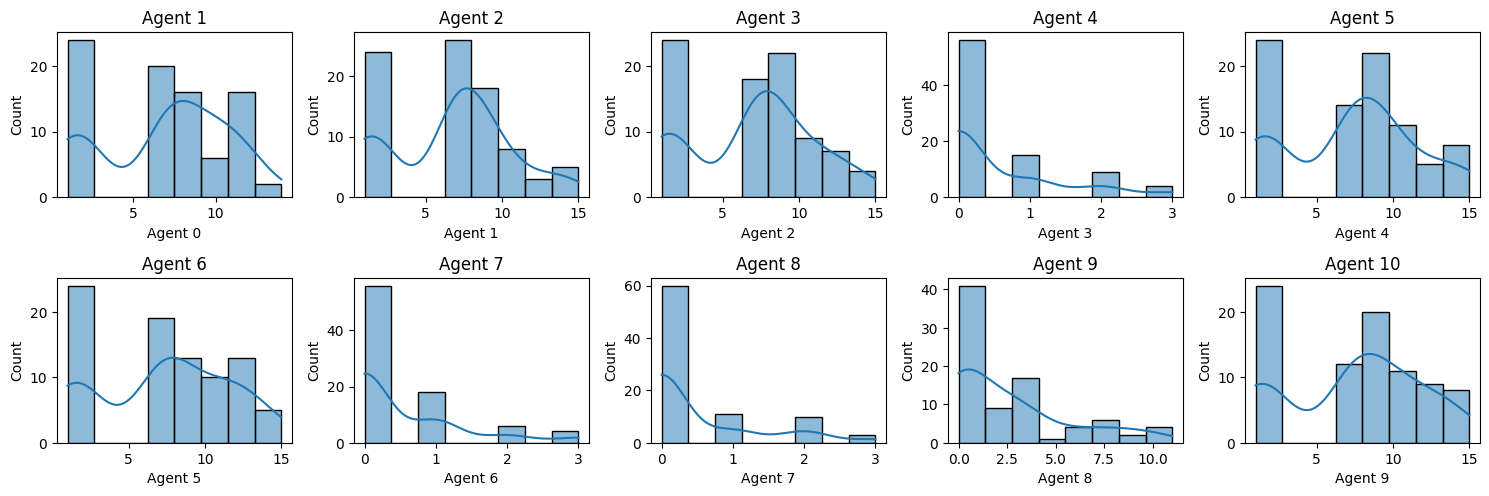

In [42]:
# Checking the data distribution using histograms (each agent)
plt.figure(figsize=(15,12))
NoOfPlots = min(df_no_outliers.shape[0], 10) # limits no. of plots to 10 agents

for i in range(NoOfPlots):
    plt.subplot(5, 5, 1+i)
    sns.histplot(df_no_outliers.iloc[i], kde=True)
    plt.title(f'Agent {i+1}')
    
plt.tight_layout()
plt.show()

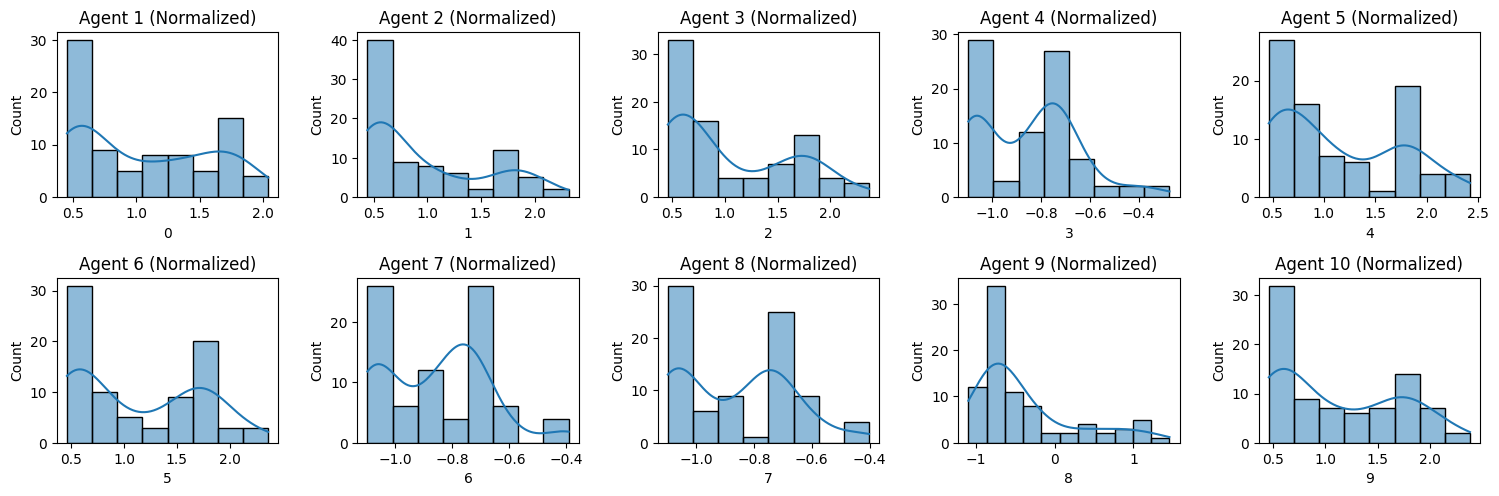

In [44]:
# Normalize the data using StandardScaler and re-plot the histograms
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_no_outliers)
df_normalized = pd.DataFrame(df_normalized, columns = df_no_outliers.columns)

# Plotting the Normalized dataset
plt.figure(figsize=(15,12))
NoOfPlots = min(df_normalized.shape[0], 10) # limits no. of plots to 10 agents

for i in range(NoOfPlots):
    plt.subplot(5, 5, i+1)
    sns.histplot(df_normalized.iloc[i], kde=True)
    plt.title(f'Agent {i+1} (Normalized)')
    
plt.tight_layout()
plt.show()